Epoch 1/100
3125/3125 [==============================] - 1s 269us/step - loss: 2.8157
Epoch 2/100
3125/3125 [==============================] - 1s 274us/step - loss: 0.7006
Epoch 3/100
3125/3125 [==============================] - 1s 270us/step - loss: 0.1422
Epoch 4/100
3125/3125 [==============================] - 1s 266us/step - loss: 0.0238
Epoch 5/100
3125/3125 [==============================] - 1s 279us/step - loss: 0.0023
Epoch 6/100
3125/3125 [==============================] - 1s 301us/step - loss: 1.0252e-04
Epoch 7/100
3125/3125 [==============================] - 1s 276us/step - loss: 2.5627e-04
Epoch 8/100
3125/3125 [==============================] - 1s 244us/step - loss: 2.4432e-04
Epoch 9/100
3125/3125 [==============================] - 1s 267us/step - loss: 2.6163e-04
Epoch 10/100
3125/3125 [==============================] - 1s 264us/step - loss: 2.4764e-04
Epoch 11/100
3125/3125 [==============================] - 1s 268us/step - loss: 2.4991e-04
Epoch 12/100
3125/3125 [====

3125/3125 [==============================] - 1s 259us/step - loss: 2.2337e-04
Epoch 92/100
3125/3125 [==============================] - 1s 274us/step - loss: 2.2731e-04
Epoch 93/100
3125/3125 [==============================] - 1s 271us/step - loss: 2.2715e-04
Epoch 94/100
3125/3125 [==============================] - 1s 273us/step - loss: 2.3462e-04 0s - loss: 2.
Epoch 95/100
3125/3125 [==============================] - 1s 290us/step - loss: 2.2188e-04
Epoch 96/100
3125/3125 [==============================] - 1s 276us/step - loss: 2.2966e-04
Epoch 97/100
3125/3125 [==============================] - 1s 270us/step - loss: 2.1688e-04
Epoch 98/100
3125/3125 [==============================] - 1s 265us/step - loss: 2.2118e-04
Epoch 99/100
3125/3125 [==============================] - 1s 279us/step - loss: 2.1801e-04
Epoch 100/100
3125/3125 [==============================] - 1s 264us/step - loss: 2.2474e-04


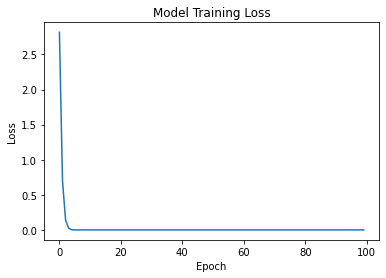

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Generate synthetic data
# These variables define the dimensions and latent factors for the synthetic data. 
#num_users represents the number of users, num_items represents the number of items, 
#num_features represents the number of features, and latent_dim represents the dimensionality of the latent space.

num_users = 100
num_items = 50
num_features = 10
latent_dim = 3

# Randomly initialize user, item, and feature matrices

user_matrix = np.random.randn(num_users, latent_dim)
item_matrix = np.random.randn(num_items, latent_dim)
feature_matrix = np.random.randn(num_features, latent_dim)


# Generate ratings based on latent factors
'''
This line generates the ratings based on the latent factors. 
It uses np.einsum to perform element-wise multiplication across the three latent dimensions, 
resulting in a tensor of ratings. 
The dimensions of the ratings tensor are (num_users, num_items, num_features).
'''
ratings = np.einsum('ij,kj,lj->ikl', user_matrix, item_matrix, feature_matrix)

# Convert ratings to a tensor
# This line converts the ratings tensor into a TensorFlow constant. 
# This step is necessary for TensorFlow to perform computations on the data.

ratings_tensor = tf.constant(ratings, dtype=tf.float32)

# Define the model architecture
class LatentTensorFactorModel(tf.keras.Model):
    def __init__(self, num_users, num_items, num_features, latent_dim):
        super(LatentTensorFactorModel, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users, latent_dim)
        self.item_embedding = tf.keras.layers.Embedding(num_items, latent_dim)
        self.feature_embedding = tf.keras.layers.Embedding(num_features, latent_dim)
        
    def call(self, inputs):
        user_indices, item_indices, feature_indices = inputs[:, 0], inputs[:, 1], inputs[:, 2]
        user_embed = self.user_embedding(user_indices)
        item_embed = self.item_embedding(item_indices)
        feature_embed = self.feature_embedding(feature_indices)
        return tf.reduce_sum(user_embed * item_embed * feature_embed, axis=1)
'''
These lines define the model architecture using TensorFlow's Keras API. 
The LatentTensorFactorModel class inherits from tf.keras.Model 
and overrides the __init__ and call methods. 
In the constructor, the model initializes three embedding layers for users, items, and features, respectively. 
In the call method, the model takes user, item, and feature indices as inputs, and it retrieves the corresponding embeddings from the embedding layers. It then 
performs element-wise multiplication and reduces the sum along the latent dimension to produce the predicted ratings.
'''



# Create an instance of the model
model = LatentTensorFactorModel(num_users, num_items, num_features, latent_dim)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
'''
This line compiles the model by specifying the optimizer (Adam) and the loss function (mean squared error). 
The optimizer determines the update rules for the model's parameters during training, 
and the loss function measures the discrepancy between the predicted ratings and the true ratings.
'''

# Train the model
batch_size = 16
num_epochs = 100
history = model.fit(x=np.column_stack(np.where(ratings_tensor != 0)),
                    y=ratings_tensor[ratings_tensor != 0],
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1)
'''
This block of code trains the model. 
It uses the fit method of the model to train the embeddings using the non-zero ratings. 
The x argument represents the input indices obtained by stacking the indices of non-zero ratings along columns using np.column_stack(np.where(ratings_tensor != 0)). The y argument represents the target ratings. The batch_size specifies the number of samples per gradient update, and num_epochs specifies the number of times the entire dataset is iterated over during training. 
The verbose parameter set to 1 displays the training progress.
'''

# Plot the training loss over time
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


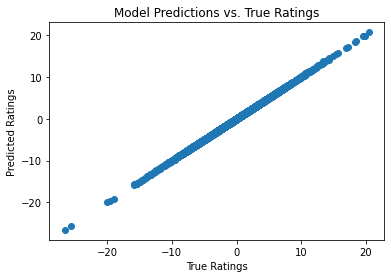

In [6]:
indices = np.array(np.indices(ratings.shape)).reshape(3, -1).T
predicted_ratings = model.predict(indices).reshape(ratings.shape)

plt.scatter(ratings.flatten(), predicted_ratings.flatten())
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Model Predictions vs. True Ratings')
plt.show()


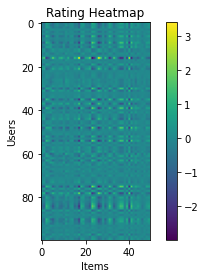

In [7]:
plt.imshow(ratings.mean(axis=2))
plt.colorbar()
plt.xlabel('Items')
plt.ylabel('Users')
plt.title('Rating Heatmap')
plt.show()
